In [1]:
import pickle
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tqdm import tqdm

In [2]:
# Read the data
CONDITION_PROCESSED_FILE = '../data/processed/conditions002.csv'
CONTROL_PROCESSED_FILE = '../data/processed/controls002.csv'

conditions = pd.read_csv(CONDITION_PROCESSED_FILE)
controls = pd.read_csv(CONTROL_PROCESSED_FILE)

# Combine the data
data = conditions.append(controls, ignore_index=True)

# Shuffle the data
data = data.sample(frac=1)

In [6]:
data.describe()

,act_mean,act_median,act_std,sleep_ef,total_smin,wake_so,wake_eps,state
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000,3412.000000
mean,14.201279,2.980510,34.769590,93.219176,135.766999,8.316530,3.514654,0.533998
std,10.670290,6.101673,26.054832,9.155447,436.705393,12.813757,5.531400,0.498916
min,0.000000,0.000000,0.000000,47.058824,9.000000,0.000000,0.000000,0.000000
25%,6.326905,0.000000,16.132935,90.000000,17.000000,0.000000,0.000000,0.000000
50%,12.097619,0.000000,30.637082,96.696942,38.000000,2.000000,1.000000,1.000000
75%,20.010791,3.000000,48.635583,100.000000,142.000000,12.000000,5.000000,1.000000
max,121.045455,45.000000,309.568098,100.000000,10882.000000,105.000000,46.000000,1.000000


In [7]:
data.shape

(3412, 8)

In [8]:
data.state.value_counts(normalize=True) * 100

1    53.399766
0    46.600234
Name: state, dtype: float64

The dataset reveals that the probability of picking a depressed person at random is 53%. A naive model that predicts that a given patient is depressed would be 53% correct.

The baseline model is 73% which is the current state of the art.

In [9]:
X = data.drop('state', axis=1)
y = data.state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [10]:
# Scale the data to a mean of 0 and std of 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# initialize the model to try out

model_dict = {
    'rnd_clf': RandomForestClassifier(n_estimators=100, max_depth=12),
    'svc_clf': SVC(C=1),
    'gnb_clf': GaussianNB(),
    'xgb_clf': XGBClassifier(n_estimators=100, max_depth=2, use_label_encoder=False),
}

In [12]:
for key, model in model_dict.items():
    model.fit(X_train_scaled, y_train)

[11:31:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
model_metrics = []

for key, model in model_dict.items():
    f1 = f1_score(y_test, model.predict(X_test_scaled))
    acc = accuracy_score(y_test, model.predict(X_test_scaled))
    model_metrics.append([key, f1, acc])
pd.DataFrame(model_metrics, columns=["model name", "f1 score", 
"accuracy"])

,model name,f1 score,accuracy
0,rnd_clf,0.636475,0.565154
1,svc_clf,0.657926,0.579795
2,gnb_clf,0.689218,0.569546
3,xgb_clf,0.678967,0.617862


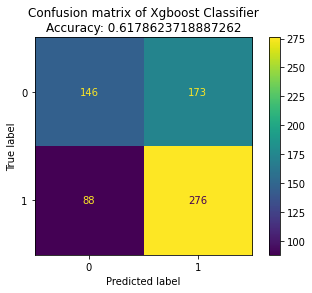

In [21]:
# confusion matric of xgb_clf
acc = model_dict['xgb_clf'].score(X_test_scaled, y_test)
conf_mat = plot_confusion_matrix(model_dict['xgb_clf'], X_test_scaled, y_test)
plt.title(f'Confusion matrix of Xgboost Classifier\nAccuracy: {acc}')
plt.show()

In [22]:
model =  XGBClassifier(n_estimators=100, use_label_encoder=False)

In [23]:
param_grid = {
    'learning_rate': np.linspace(0.01, 0.08, 30),
    'max_depth': range(4, 7),
    'colsample_bytree': np.linspace(0.62, 1, 30),
    'subsample': np.linspace(0.5, 0.9, 30),
    'gamma': np.linspace(0.06, 0.8, 30),
    'min_child_weight': np.linspace(1, 3.9, 30)
}

best_params_list = []
for i in tqdm(range(0, 10)):
    rs = RandomizedSearchCV(model, param_grid, n_iter=500, n_jobs=-1, cv=5, scoring='accuracy')
    rs.fit(X_train_scaled, y_train)
    rs.best_params_['acc'] = rs.best_estimator_.score(X_test_scaled, y_test)
    best_params_list.append(rs.best_params_)
    
best_params_df = pd.DataFrame(best_params_list)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[11:45:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 10%|████████                                                                        | 1/10 [09:17<1:23:34, 557.21s/it]

[11:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 20%|████████████████                                                                | 2/10 [17:11<1:07:46, 508.37s/it]

[12:00:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 30%|████████████████████████▌                                                         | 3/10 [24:08<54:27, 466.80s/it]

[12:07:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 40%|████████████████████████████████▊                                                 | 4/10 [31:31<45:43, 457.30s/it]

[12:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████████████████████████████████████████                                         | 5/10 [39:24<38:35, 463.12s/it]

[12:22:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 60%|█████████████████████████████████████████████████▏                                | 6/10 [46:14<29:39, 444.86s/it]

[12:28:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [52:13<20:50, 416.96s/it]

[12:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [58:11<13:16, 398.16s/it]

[12:40:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:04:10<06:25, 385.85s/it]

[12:46:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:10:03<00:00, 420.37s/it]


In [24]:
best_params_df.describe()

,subsample,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree,acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.728966,3.050000,4.200000,0.071069,0.343241,0.934483,0.586384
std,0.102230,0.808634,0.421637,0.006238,0.173671,0.033264,0.006911
min,0.513793,1.800000,4.000000,0.058276,0.162069,0.895172,0.578331
25%,0.706897,2.625000,4.000000,0.068534,0.213103,0.908276,0.581259
50%,0.775862,3.200000,4.000000,0.071552,0.302414,0.921379,0.584187
75%,0.800000,3.700000,4.000000,0.074569,0.391724,0.967241,0.592240
max,0.803448,3.900000,5.000000,0.080000,0.646897,0.986897,0.597365


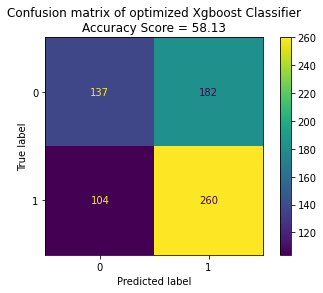

In [25]:
acc = rs.best_estimator_.score(X_test_scaled, y_test)
conf_mat = plot_confusion_matrix(rs.best_estimator_, X_test_scaled, y_test)
plt.title(f'Confusion matrix of optimized Xgboost Classifier\nAccuracy Score = {acc * 100:.2f}')
plt.show()

In [26]:
model =  XGBClassifier(n_estimators=100, max_depth=2, use_label_encoder=False)

In [27]:
model.fit(X_train_scaled, y_train)

[13:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)